In [90]:
import pandas as pd
import np
import requests
from urllib.parse import quote
from urllib.parse import quote_plus
from dotenv import load_dotenv
from os import getenv
load_dotenv()

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

ModuleNotFoundError: No module named 'np'

In [116]:
import requests
import pandas as pd
from urllib.parse import quote_plus
from os import getenv
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time  # For adding delays between API calls

# Your Scopus API key
API_KEY = getenv('SCOPUS_API_KEY')

# Verify that the API key was retrieved successfully
if not API_KEY:
    raise ValueError("API key not found. Please ensure 'SCOPUS_API_KEY' is set in your environment variables.")

# Base URLs for the Scopus API
SEARCH_URL = 'https://api.elsevier.com/content/search/scopus'
ABSTRACT_URL = 'https://api.elsevier.com/content/abstract/eid/'

# Initialize variables
count = 25  # Adjust based on your service level
articles = []

# Define the range of years you want to retrieve data for
years = np.arange(2013, 2024)  # Adjust the years as needed

# Loop over each year to handle the 5,000 results limit per query
for year in years:
    start = 0
    total_results = None
    while True:
        # Define the main query
        main_query = "('reliance' OR 'appropriate reliance') AND ('human-AI' OR 'AI-assisted') AND 'decision making'"

        # Construct the query using TITLE-ABS-KEY
        query = f"TITLE-ABS-KEY({main_query}) AND PUBYEAR = {year}"

        # URL encode the query
        encoded_query = quote_plus(query)

        # Construct the API URL with the correct 'apiKey' parameter name
        url = f"{SEARCH_URL}?query={encoded_query}&apiKey={API_KEY}&start={start}&count={count}"

        # Send the request to the Scopus API
        response = requests.get(url, headers={"Accept": "application/json"})

        # Check for a successful response
        if response.status_code == 200:
            data = response.json()

            # Get total number of results
            if total_results is None:
                total_results = int(data['search-results']['opensearch:totalResults'])
                print(f"Year: {year}, Total Results Found: {total_results}")

                # If no results are found for the year, break the loop
                if total_results == 0:
                    break

            # Extract articles
            entries = data['search-results'].get('entry', [])
            for entry in entries:
                articles.append({
                    "Title": entry.get('dc:title', 'No Title'),
                    "Authors": entry.get('dc:creator', 'No Authors'),
                    "Publication": entry.get('prism:publicationName', 'No Publication Name'),
                    "Year": entry.get('prism:coverDate', 'No Publication Year'),
                    "DOI": entry.get('prism:doi', 'No DOI'),
                    "EID": entry.get('eid', 'No EID')  # Collect the EID for abstract retrieval
                })

            # Update the starting index for the next request
            start += count

            # Check if all results for the year are retrieved or if we've reached the API's maximum per query
            if start >= total_results or start >= 5000:
                break
        else:
            print(f"Error: {response.status_code}")
            print(f"Response: {response.text}")
            break

# Convert the list of dictionaries into a DataFrame
df = pd.DataFrame(articles)
print(f"Total articles retrieved: {df.shape[0]}")

# Function to retrieve abstract for a given EID
def get_abstract(eid, api_key):
    url = f"{ABSTRACT_URL}{eid}?apiKey={api_key}&view=FULL"
    headers = {'Accept': 'application/json'}
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        data = response.json()
        # Extract the abstract text
        abstract = data.get('abstracts-retrieval-response', {}).get('coredata', {}).get('dc:description', '')
        return abstract
    else:
        print(f"Error retrieving abstract for EID {eid}: {response.status_code}")
        return ''

# Add a new column 'Abstract' to the DataFrame
df['Abstract'] = ''

# Retrieve abstracts for each article (be cautious with API limits)
for index, row in df.iterrows():
    eid = row['EID']
    if eid != 'No EID':
        abstract = get_abstract(eid, API_KEY)
        df.at[index, 'Abstract'] = abstract
        time.sleep(0.2)  # Sleep for 0.2 seconds to avoid overwhelming the API
    else:
        df.at[index, 'Abstract'] = ''

# Proceed with data analysis and visualization

# Example: Print the first few articles with abstracts
print(df[['Title', 'Abstract']].head())

# You can also save the DataFrame to a CSV file for further analysis
df.to_csv('scopus_articles_with_abstracts.csv', index=False)


Year: 2013, Total Results Found: 0
Year: 2014, Total Results Found: 0
Year: 2015, Total Results Found: 0
Year: 2016, Total Results Found: 0
Year: 2017, Total Results Found: 0
Year: 2018, Total Results Found: 0
Year: 2019, Total Results Found: 0
Year: 2020, Total Results Found: 0
Year: 2021, Total Results Found: 3
Year: 2022, Total Results Found: 13
Year: 2023, Total Results Found: 25
Total articles retrieved: 41
Error retrieving abstract for EID 2-s2.0-85109039534: 401
Error retrieving abstract for EID 2-s2.0-85106763897: 401
Error retrieving abstract for EID 2-s2.0-85103464614: 401
Error retrieving abstract for EID 2-s2.0-85140122351: 401
Error retrieving abstract for EID 2-s2.0-85124266129: 401
Error retrieving abstract for EID 2-s2.0-85146372689: 401
Error retrieving abstract for EID 2-s2.0-85142189773: 401
Error retrieving abstract for EID 2-s2.0-85126057122: 401
Error retrieving abstract for EID 2-s2.0-85130576246: 401
Error retrieving abstract for EID 2-s2.0-85130556468: 401
Erro

In [118]:
# Convert the list of dictionaries into a DataFrame
df = pd.DataFrame(articles)
print(f"Total articles retrieved: {df.shape[0]}")

# Proceed with data analysis and visualization

# Convert 'Year' to datetime and extract the year
df['Year'] = pd.to_datetime(df['Year'], errors='coerce').dt.year

# Drop rows with NaN in 'Year'
df = df.dropna(subset=['Year'])

# Convert 'Year' to integer
df['Year'] = df['Year'].astype(int)

# Group by 'Year' and count the publications
year_counts = df.groupby('Year').size().reset_index(name='Counts')

Total articles retrieved: 41


In [119]:
df

,Title,Authors,Publication,Year,DOI,EID
0,You'd Better Stop! Understanding Human Relianc...,Chiang C.W.,ACM International Conference Proceeding Series,2021,10.1145/3447535.3462487,2-s2.0-85109039534
1,Human reliance on machine learning models when...,Lu Z.,Conference on Human Factors in Computing Syste...,2021,10.1145/3411764.3445562,2-s2.0-85106763897
2,What if an AI told you that 2 + 2 is 5? Confor...,Liel Y.,International Conference on Information System...,2021,No DOI,2-s2.0-85103464614
3,AI-Assisted Decision-making: a Cognitive Model...,Tejeda H.,Computational Brain and Behavior,2022,10.1007/s42113-022-00157-y,2-s2.0-85140122351
4,Convolutional mesh autoencoders for the 3-dime...,O’ Sullivan E.,Scientific Reports,2022,10.1038/s41598-021-02411-y,2-s2.0-85124266129
5,Understanding User Reliance on AI in Assisted ...,Cao S.,Proceedings of the ACM on Human-Computer Inter...,2022,10.1145/3555572,2-s2.0-85146372689
6,An Empirical Investigation of Reliance on AI-A...,Tejeda Lemus H.,Frontiers in Artificial Intelligence and Appli...,2022,10.3233/FAIA220201,2-s2.0-85142189773
7,The effects of domain knowledge on trust in ex...,Dikmen M.,International Journal of Human Computer Studies,2022,10.1016/j.ijhcs.2022.102792,2-s2.0-85126057122
8,Capable but Amoral? Comparing AI and Human Exp...,Tolmeijer S.,Conference on Human Factors in Computing Syste...,2022,10.1145/3491102.3517732,2-s2.0-85130576246
9,Improving Human-AI Partnerships in Child Welfa...,Kawakami A.,Conference on Human Factors in Computing Syste...,2022,10.1145/3491102.3517439,2-s2.0-85130556468


In [120]:
# Group by 'Year' and count the publications
year_counts = df.groupby('Year').size().reset_index(name='Counts')

In [101]:
year_counts

,Year,Counts
0,2021,3
1,2022,12
2,2023,21


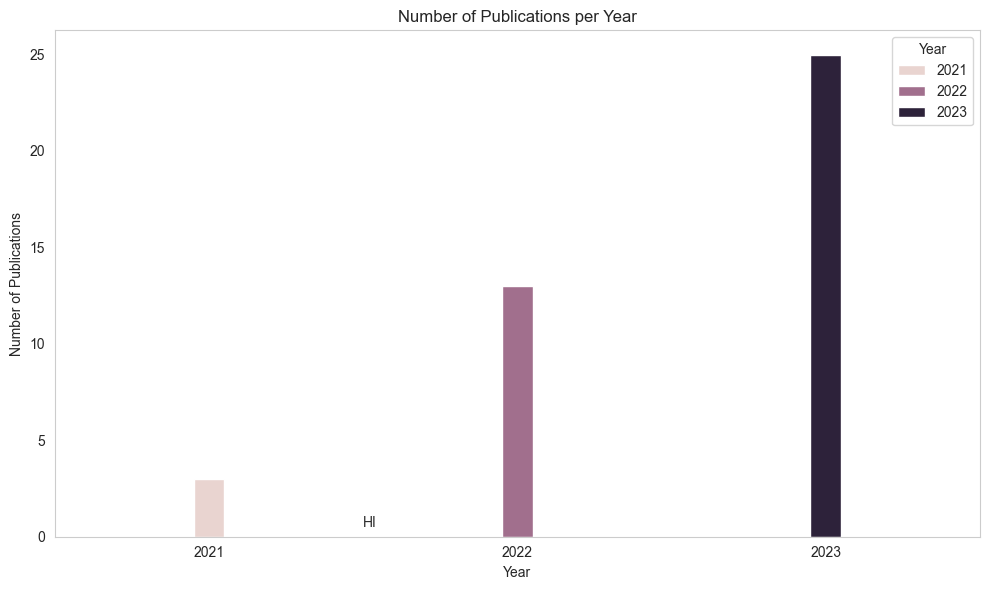

In [124]:
# Create a figure and axis
fig , ax = plt.subplots(figsize=(10,6))

# Plot the bar chart
ax = sns.barplot(data=year_counts, x='Year', width=.1, y='Counts', hue='Year')
ax.text(.5,.5,'HI')
# Customize the plot
plt.title('Number of Publications per Year')
plt.xlabel('Year')
plt.ylabel('Number of Publications')
plt.xticks(rotation=0)
plt.grid(False)
# Adjust layout and display the plot
plt.tight_layout()
plt.show()